In [1]:
import dotenv
dotenv.load_dotenv()

True

In [2]:
from langchain.utilities.tavily_search import TavilySearchAPIWrapper
from langchain.tools.tavily_search import TavilySearchResults

tavily_tool = TavilySearchResults(api_wrapper=TavilySearchAPIWrapper())


from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper

wikipedia = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper())

available_tools = [tavily_tool, wikipedia]
# wikipedia

In [3]:

from langchain_core.pydantic_v1 import BaseModel, Field, validator
from langchain.output_parsers import PydanticOutputParser


In [4]:

from typing import List
class Question(BaseModel):
    ask_to: str = Field(description="Expert To Ask the Question To")
    question: str = Field(description="Question to ask the respective expert to get their opinion")

class QuestionsList(BaseModel):
    questions: List[Question] = Field(description="List of questions to ask to various experts")
questions_list_parser = PydanticOutputParser(pydantic_object=QuestionsList)


In [5]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(temperature=0)

In [6]:
members = {
    "MarketExpert":"Market expert in london regarding rental and on-sale properties.", 
    "LocationExpert":"Location expert and strategist in london", 
    "FinanceExpert":"Financial Expert in London"
}

In [7]:
from langchain.prompts import PromptTemplate
from langchain_core.messages import SystemMessage, AIMessage
prompt_to_head_string = (
    "You are a head of a real estate company. "
    "You've following co-workers in your company: {members}. "
    "User Asks the following: \n{query}\n"
    "Based on the user query, generate ten or more questions to ask one or more experts. "
    "Make sure you ask the experts the questions based on their expertise."
    "\n{format_instructions}"
)
prompt_to_head = PromptTemplate(
    template=prompt_to_head_string,
    input_variables=["query"],
    partial_variables={"members":members, "format_instructions":questions_list_parser.get_format_instructions()}
)
query_generation_chain = prompt_to_head | llm | questions_list_parser



In [8]:
questions_list_parser

PydanticOutputParser(pydantic_object=<class '__main__.QuestionsList'>)

In [9]:
# response

## Create Expert Members/Agents (definition)

In [10]:
from langchain.prompts import PromptTemplate, MessagesPlaceholder, ChatPromptTemplate
from langchain.agents import AgentExecutor, create_openai_tools_agent

from langchain.agents.format_scratchpad.openai_tools import (
    format_to_openai_tool_messages,
)

from langchain.agents.output_parsers.openai_tools import OpenAIToolsAgentOutputParser


def create_expert(tools, role, role_description):

    sys_prompt_str = ("You're an expert of a real estate consultancy. "+
            "Your expertise is "+role+" (Description: "+role_description+"). ")
    
    prompt_str = (
        "You're asked the following by the head of the consultancy. \n"
        "{input}\n"
        "Based on the query, give a short and concise answer, two or three sentences in plain readable text. "
        "Use Tools if necessary. "
    )
    sprompt = ChatPromptTemplate.from_messages([
        (
            "system", sys_prompt_str
        ),
        ("user", prompt_str),
        MessagesPlaceholder(variable_name="agent_scratchpad")
    ])
    llm_with_tools = llm.bind_tools(tools)
    agent = (
                {
                    "input": lambda x: x["input"],
                    "agent_scratchpad": lambda x: format_to_openai_tool_messages(
                        x["intermediate_steps"]
                    ),
                }
                | sprompt
                | llm_with_tools
                | OpenAIToolsAgentOutputParser()
            )
    agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=False)
    return agent_executor


## Create Expert Members/Agents (instantiation)

In [11]:
marketing_agent = create_expert(available_tools, "MarketExpert", members["MarketExpert"])

def marketing_agent_node(q):
    resp = marketing_agent.invoke(dict(input=q, tools=available_tools))
    return resp['output']

def market_expert_statenode(state):
    to_ask_q = state['unsolved_questions'][0]
    state['unsolved_questions'] = state['unsolved_questions'][1:]
    state['done_list_questions'].append((
                to_ask_q.ask_to,
                to_ask_q.question,
                marketing_agent.invoke(dict(input=to_ask_q.question, tools=available_tools))['output']
            ))
    return dict(unsolved_questions=state['unsolved_questions'], done_list_questions=state['done_list_questions'])

finance_agent = create_expert(available_tools, "FinanceExpert", members["FinanceExpert"])

def finance_agent_node(q):
    resp = finance_agent.invoke(dict(input=q, tools=available_tools))
    return resp['output']

def finance_expert_statenode(state):
    to_ask_q = state['unsolved_questions'][0]
    state['unsolved_questions'] = state['unsolved_questions'][1:]
    state['done_list_questions'].append((
                to_ask_q.ask_to,
                to_ask_q.question,
                finance_agent.invoke(dict(input=to_ask_q.question, tools=available_tools))['output']
            ))
    return dict(unsolved_questions=state['unsolved_questions'], done_list_questions=state['done_list_questions'])



location_agent = create_expert(available_tools, "LocationExpert", members["LocationExpert"])

def location_agent_node(q):
    resp = location_agent.invoke(dict(input=q, tools=available_tools))
    return resp['output']


def location_expert_statenode(state):
    to_ask_q = state['unsolved_questions'][0]
    state['unsolved_questions'] = state['unsolved_questions'][1:]
    state['done_list_questions'].append((
                to_ask_q.ask_to,
                to_ask_q.question,
                location_agent.invoke(dict(input=to_ask_q.question, tools=available_tools))['output']
            ))
    return dict(unsolved_questions=state['unsolved_questions'], done_list_questions=state['done_list_questions'])



agent_nodes_map = dict(
    MarketExpert=marketing_agent_node,
    FinanceExpert=finance_agent_node,
    LocationExpert=location_agent_node
)




In [12]:
def generate_queries(state):
    responses = query_generation_chain.invoke(dict(query=state.get('user_query'))).questions
    
    return {'unsolved_questions': responses, 'done_list_questions':[]}

# response.questions

In [13]:

def qa_mapping_to_prompt(q):
    return "\n\n".join(["Question: "+i[1]+"\nAnswer: "+i[2] for i in q])

In [14]:

# qam = ask_questions_to_expert(response)

In [15]:
# qam_s = qa_mapping_to_prompt(qam)
# print(qam_s)

In [14]:
def process_queries(state):
    uns = state.get('unsolved_questions')
    if len(uns)==0:
        state['ask_to_expert'] = "_continue_"
        return {**state}
    return {'ask_to_expert':"askto"+uns[0].ask_to}



processing_prompt_template = (
    "```plain_text\n{summary}\n```\n"
    "Based on the above expert's QnA, respond the following client's query. Make sure you conclude with concise reasoning. \n"
    "{client_query}"
)
processing_prompt = PromptTemplate.from_template(processing_prompt_template)
process_expert_chain = processing_prompt | llm
def process_expert_responses(state):
    summary_mapping = qa_mapping_to_prompt(state['done_list_questions'])
    respo = process_expert_chain.invoke(dict(summary=summary_mapping, client_query=state['user_query'])).content
    return dict(client_response=respo)


In [15]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, List
    
class AppState(TypedDict):
    user_query: str = ""
    unsolved_questions:List[Question] = []
    done_list_questions:List = []
    ask_to_expert: str
    client_response: str

workflow = StateGraph(AppState)
workflow.add_node("generate_queries", generate_queries)
workflow.add_node("process_queries", process_queries)

workflow.add_edge("generate_queries", "process_queries")


workflow.add_node("MarketExpert", market_expert_statenode)
workflow.add_node("FinanceExpert", finance_expert_statenode)
workflow.add_node("LocationExpert", location_expert_statenode)

workflow.add_edge("MarketExpert", "process_queries")
workflow.add_edge("FinanceExpert", "process_queries")
workflow.add_edge("LocationExpert", "process_queries")

workflow.add_node("process_expert_responses", process_expert_responses)
workflow.add_edge("process_expert_responses", END)

workflow.add_conditional_edges("process_queries", lambda x: x['ask_to_expert'], 
                               dict(
                                   asktoMarketExpert="MarketExpert", 
                                   asktoFinanceExpert="FinanceExpert", 
                                   asktoLocationExpert="LocationExpert",
                                   _continue_="process_expert_responses"
                               )
                              )






workflow.add_edge(START, "generate_queries")




# workflow.add

app = workflow.compile()

In [16]:
# end_state['client_response']

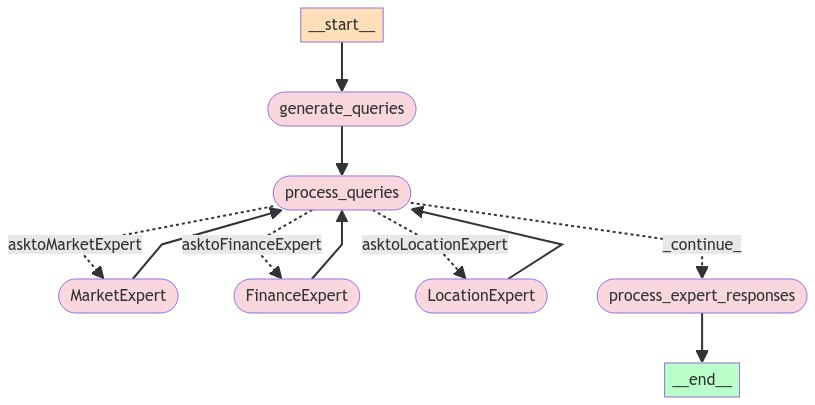

In [17]:
from IPython.display import Image, display

display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [18]:
def real_estate_query(q, recursion_limit=100):
    end_state = app.invoke(
        input=dict(user_query=(
            q
        )),
        config=dict(recursion_limit=recursion_limit)
    )
    return end_state['client_response']


In [60]:
from langchain_core.output_parsers import JsonOutputParser

class Scoring(BaseModel):
    score: int 

parser = JsonOutputParser(pydantic_object=Scoring)

validation_prompt = PromptTemplate.from_template(
    "You're a answer validatior. "
    "You'll be given a question,  a correct answer and written answer. "
    "You'll have to score the written answer out of 10 given the ideal answer is correct answer. "
    # "Donot hesitate to give full or high score if the answer seems fairly correct and vice versa. "
    "Score Strictly. Give very low score for unsatisfactory answer and very high score for good asnwers."
    "Question: `{question}`"
    "Correct Answer: `{correct_answer}`"
    "Written Answer: `{written_answer}`"
    "\n\n{format_instructions}"
, partial_variables={"format_instructions":parser.get_format_instructions()})

validation_chain = validation_prompt | llm | parser



Failed to batch ingest runs: LangSmithRateLimitError('Rate limit exceeded for https://api.smith.langchain.com/runs/batch. HTTPError(\'429 Client Error: Too Many Requests for url: https://api.smith.langchain.com/runs/batch\', \'{"detail":"Hourly events ingested usage limit exceeded"}\')')


In [49]:
import json

dataset = json.load(open("datasets/qa_list_specified.json"))
len(dataset)

265

Failed to batch ingest runs: LangSmithConnectionError('Connection error caused failure to POST https://api.smith.langchain.com/runs/batch  in LangSmith API. Please confirm your internet connection.. SSLError(MaxRetryError("HTTPSConnectionPool(host=\'api.smith.langchain.com\', port=443): Max retries exceeded with url: /runs/batch (Caused by SSLError(SSLEOFError(8, \'EOF occurred in violation of protocol (_ssl.c:2406)\')))"))')
Failed to batch ingest runs: LangSmithConnectionError('Connection error caused failure to POST https://api.smith.langchain.com/runs/batch  in LangSmith API. Please confirm your internet connection.. SSLError(MaxRetryError("HTTPSConnectionPool(host=\'api.smith.langchain.com\', port=443): Max retries exceeded with url: /runs/batch (Caused by SSLError(SSLEOFError(8, \'EOF occurred in violation of protocol (_ssl.c:2406)\')))"))')
Failed to batch ingest runs: LangSmithConnectionError('Connection error caused failure to POST https://api.smith.langchain.com/runs/batch  i

In [24]:
to_validiate_data = dataset[0]

In [ ]:
# %timeit
# model_response = real_estate_query(to_validiate_data['question'])

In [ ]:





# resp = validation_chain.invoke(
#     dict(
#         question=to_validiate_data['question'], 
#         written_answer=model_response, 
#         correct_answer=to_validiate_data['answer']
#     )
#                               )

In [20]:
import concurrent.futures

# Define the function to generate responses for a given index
def generate_response_for_index(index, dataset_list):
    to_validate_data = dataset_list[index]
    model_response = real_estate_query(to_validate_data['question'])
    dataset_list[index]['model_response'] = model_response


def gen_val_for_index(index, dataset_list):
    dt = dataset_list[index]
    score = validation_chain.invoke(dict(correct_answer=dt['answer'], written_answer=dt['model_response'], question=dt['question']))
    dataset_list[index]['score'] = score['score']
    

# Create a function to run the multithreading
def run_multithreading(dataset_list,fn=generate_response_for_index, max_workers=15):
    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        # Create a list of tasks for the executor
        tasks = [executor.submit(fn, index, dataset_list) for index in range(len(dataset_list))]
        # Ensure all tasks are completed
        for task in concurrent.futures.as_completed(tasks):
            pass



# scores_mock_dt = json.load(open("model_response_sum0.json")



In [62]:
# mock_dt = dataset.copy()
# run_multithreading(mock_dt, max_workers=50)


C:\Users\sarth\anaconda3\envs\advisor\Lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("html.parser"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file C:\Users\sarth\anaconda3\envs\advisor\Lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="html.parser"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')
C:\Users\sarth\anaconda3\envs\advisor\Lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("html.parser"). This usually isn't a problem, but if you run this code on another system, or in a differe

In [63]:
[(i, m.keys()) for i,m in enumerate(mock_dt)]

[(0, dict_keys(['question', 'answer', 'model_response'])),
 (1, dict_keys(['question', 'answer', 'model_response'])),
 (2, dict_keys(['question', 'answer', 'model_response'])),
 (3, dict_keys(['question', 'answer', 'model_response'])),
 (4, dict_keys(['question', 'answer', 'model_response'])),
 (5, dict_keys(['question', 'answer', 'model_response'])),
 (6, dict_keys(['question', 'answer', 'model_response'])),
 (7, dict_keys(['question', 'answer', 'model_response'])),
 (8, dict_keys(['question', 'answer', 'model_response'])),
 (9, dict_keys(['question', 'answer', 'model_response'])),
 (10, dict_keys(['question', 'answer', 'model_response'])),
 (11, dict_keys(['question', 'answer', 'model_response'])),
 (12, dict_keys(['question', 'answer', 'model_response'])),
 (13, dict_keys(['question', 'answer', 'model_response'])),
 (14, dict_keys(['question', 'answer', 'model_response'])),
 (15, dict_keys(['question', 'answer', 'model_response'])),
 (16, dict_keys(['question', 'answer', 'model_resp

Failed to batch ingest runs: LangSmithRateLimitError('Rate limit exceeded for https://api.smith.langchain.com/runs/batch. HTTPError(\'429 Client Error: Too Many Requests for url: https://api.smith.langchain.com/runs/batch\', \'{"detail":"Hourly events ingested usage limit exceeded"}\')')


In [44]:
# 216,223
# mdt2 = [mock_dt[223]]
# run_multithreading(mdt2, max_workers = 3)

In [65]:
# mock_dt[216] = mdt2[0]
# mock_dt[223] = mdt2[0]


import json

json.dump(mock_dt, open("model_response_sum0.json", 'w'))

Failed to batch ingest runs: LangSmithRateLimitError('Rate limit exceeded for https://api.smith.langchain.com/runs/batch. HTTPError(\'429 Client Error: Too Many Requests for url: https://api.smith.langchain.com/runs/batch\', \'{"detail":"Hourly events ingested usage limit exceeded"}\')')


In [68]:
# [(i, m.keys()) for i,m in enumerate(mock_dt)]

In [66]:

def generate_response_for_index(index, dataset_list):
    to_validiate_data = dataset_list['index']
    model_response = real_estate_query(to_validiate_data['question'])
    dataset_list[index]['model_response'] = model_response
    pass

        

In [67]:
# response_dt = json.load(open("model_response_sum0.json"))
# [(i, m.keys()) for i,m in enumerate(response_dt)]

In [69]:
run_multithreading(response_dt, fn=gen_val_for_index, max_workers=10)

Failed to batch ingest runs: LangSmithRateLimitError('Rate limit exceeded for https://api.smith.langchain.com/runs/batch. HTTPError(\'429 Client Error: Too Many Requests for url: https://api.smith.langchain.com/runs/batch\', \'{"detail":"Hourly events ingested usage limit exceeded"}\')')
Failed to batch ingest runs: LangSmithConnectionError('Connection error caused failure to POST https://api.smith.langchain.com/runs/batch  in LangSmith API. Please confirm your internet connection.. SSLError(MaxRetryError("HTTPSConnectionPool(host=\'api.smith.langchain.com\', port=443): Max retries exceeded with url: /runs/batch (Caused by SSLError(SSLEOFError(8, \'EOF occurred in violation of protocol (_ssl.c:2406)\')))"))')
Failed to batch ingest runs: LangSmithConnectionError("Connection error caused failure to POST https://api.smith.langchain.com/runs/batch  in LangSmith API. Please confirm your internet connection.. ConnectionError(ProtocolError('Connection aborted.', RemoteDisconnected('Remote en

In [70]:
[(i, m['score']) for i,m in enumerate(response_dt)]

[(0, 7),
 (1, 8),
 (2, 10),
 (3, 10),
 (4, 9),
 (5, 8),
 (6, 4),
 (7, 5),
 (8, 10),
 (9, 10),
 (10, 9),
 (11, 9),
 (12, 8),
 (13, 9),
 (14, 10),
 (15, 9),
 (16, 10),
 (17, 10),
 (18, 9),
 (19, 9),
 (20, 9),
 (21, 2),
 (22, 10),
 (23, 10),
 (24, 10),
 (25, 9),
 (26, 8),
 (27, 9),
 (28, 9),
 (29, 8),
 (30, 8),
 (31, 8),
 (32, 9),
 (33, 9),
 (34, 9),
 (35, 9),
 (36, 8),
 (37, 8),
 (38, 8),
 (39, 9),
 (40, 9),
 (41, 10),
 (42, 3),
 (43, 10),
 (44, 9),
 (45, 9),
 (46, 9),
 (47, 9),
 (48, 8),
 (49, 9),
 (50, 10),
 (51, 10),
 (52, 9),
 (53, 9),
 (54, 9),
 (55, 9),
 (56, 9),
 (57, 3),
 (58, 10),
 (59, 10),
 (60, 9),
 (61, 9),
 (62, 10),
 (63, 10),
 (64, 10),
 (65, 10),
 (66, 10),
 (67, 8),
 (68, 10),
 (69, 10),
 (70, 5),
 (71, 7),
 (72, 8),
 (73, 9),
 (74, 5),
 (75, 8),
 (76, 8),
 (77, 8),
 (78, 9),
 (79, 8),
 (80, 9),
 (81, 9),
 (82, 5),
 (83, 9),
 (84, 9),
 (85, 8),
 (86, 9),
 (87, 9),
 (88, 8),
 (89, 9),
 (90, 8),
 (91, 10),
 (92, 9),
 (93, 10),
 (94, 9),
 (95, 10),
 (96, 9),
 (97, 9),
 (98

Failed to batch ingest runs: LangSmithConnectionError('Connection error caused failure to POST https://api.smith.langchain.com/runs/batch  in LangSmith API. Please confirm your internet connection.. SSLError(MaxRetryError("HTTPSConnectionPool(host=\'api.smith.langchain.com\', port=443): Max retries exceeded with url: /runs/batch (Caused by SSLError(SSLEOFError(8, \'EOF occurred in violation of protocol (_ssl.c:2406)\')))"))')
Failed to batch ingest runs: LangSmithConnectionError('Connection error caused failure to POST https://api.smith.langchain.com/runs/batch  in LangSmith API. Please confirm your internet connection.. SSLError(MaxRetryError("HTTPSConnectionPool(host=\'api.smith.langchain.com\', port=443): Max retries exceeded with url: /runs/batch (Caused by SSLError(SSLEOFError(8, \'EOF occurred in violation of protocol (_ssl.c:2406)\')))"))')
Failed to batch ingest runs: LangSmithRateLimitError('Rate limit exceeded for https://api.smith.langchain.com/runs/batch. HTTPError(\'429 Cl

In [71]:
sum([m['score'] for i,m in enumerate(response_dt)])/265

8.60377358490566

Failed to batch ingest runs: LangSmithRateLimitError('Rate limit exceeded for https://api.smith.langchain.com/runs/batch. HTTPError(\'429 Client Error: Too Many Requests for url: https://api.smith.langchain.com/runs/batch\', \'{"detail":"Hourly events ingested usage limit exceeded"}\')')
Failed to batch ingest runs: LangSmithConnectionError("Connection error caused failure to POST https://api.smith.langchain.com/runs/batch  in LangSmith API. Please confirm your internet connection.. ConnectionError(ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')))")
Failed to batch ingest runs: LangSmithConnectionError('Connection error caused failure to POST https://api.smith.langchain.com/runs/batch  in LangSmith API. Please confirm your internet connection.. SSLError(MaxRetryError("HTTPSConnectionPool(host=\'api.smith.langchain.com\', port=443): Max retries exceeded with url: /runs/batch (Caused by SSLError(SSLEOFError(8, \'EOF occurred in vio